### Introduction

In the previous post, we implemented the upsampling and made sure it is correct
by comparing it to the implementation of the [scikit-image library](http://scikit-image.org/).
To be more specific we had _FCN-32_ _Segmentation_ network implemented which is
described in the paper _Fully convolutional networks for semantic segmentation_.

In this post we will perform a simple training: we will get a sample image from
[PASCAL VOC](http://host.robots.ox.ac.uk/pascal/VOC/) dataset along with annotation,
train our network on them and test our network on the same image. It was done this way
so that it can also be run on CPU -- it takes only 10 iterations for the training to complete.
Another point of this post is to show that segmentation that our network (FCN-32s) produces is
very coarse -- even if we run it on the same image that we were training it on. In this post
we tackle this problem by performing Conditional Random Field post-processing stage, which
refines our segmentation by taking into account pure RGB features of image and probabilities
produced by our network. Overall, we get a refined segmentation. The set-up of this post
is very simple on purpose. Similar approach to Segmentation was described in the paper
_Semantic Image Segmentation with Deep Convolutional Nets and Fully Connected CRFs_ by Chen et al.

The blog post is created using jupyter notebook. After each chunk of a code
you can see the result of its evaluation. You can also get the notebook
file from [here](http://google.com). The content of the blog post
is partially borrowed from [slim walkthough notebook](https://github.com/tensorflow/models/blob/master/slim/slim_walkthough.ipynb).

### Setup



To be able to run the code, you will need to have Tensorflow installed. I have used _r0.12_.
You will need to use [this fork of _tensorflow/models_](https://github.com/tensorflow/models/pull/684). 

I am also using scikit-image library and numpy for this tutorial plus other
dependencies. One of the ways to install them is to download _Anaconda_ software
package for python.

Follow all the other steps described in the previous posts -- it shows how to download
the _VGG-16_ model and I also forked the 

In [1]:
%matplotlib inline

from __future__ import division
import os
import tensorflow as tf
import numpy as np
from nets import vgg
from matplotlib import pyplot as plt
from preprocessing import vgg_preprocessing
from libs.scale_input_image import scale_randomly_image_with_annotation_with_fixed_size_output
from libs.training import get_valid_logits_and_labels

# Load the mean pixel values and the function
# that performs the subtraction from each pixel
from preprocessing.vgg_preprocessing import (_mean_image_subtraction, _R_MEAN, _G_MEAN, _B_MEAN)
slim = tf.contrib.slim

# Data processing

In [2]:
class_semantic_labels = {
    0:   "background",
    1:   "aeroplane",
    2:   "bicycle",
    3:   "bird",
    4:   "boat",
    5:   "bottle",
    6:   "bus",
    7:   "car",
    8:   "cat",
    9:   "chair",
    10:  "cow",
    11:  "diningtable",
    12:  "dog",
    13:  "horse",
    14:  "motorbike",
    15:  "person",
    16:  "pottedplant",
    17:  "sheep",
    18:  "sofa",
    19:  "train",
    20:  "tvmonitor",
    255: "undefined/don't care"
}
number_of_classes = 21
class_labels = [v for v in range((number_of_classes+1))]
class_labels[-1] = 255

### Upsampling helper functions and Image Loading

In [3]:
training_filenames = "/home/thalles_silva/DataPublic/PascalVoc2012/train/VOC2012/ImageSets/Segmentation/train.txt"
validation_filenames = "/home/thalles/VOC2012/ImageSets/Segmentation/val.txt"
training_images_dir = "/home/thalles_silva/DataPublic/PascalVoc2012/train/VOC2012/JPEGImages/"
training_labels_dir = "/home/thalles_silva/DataPublic/PascalVoc2012/train/VOC2012/SegmentationClass_1D/"
log_folder = '/home/thalles_silva/Thalles/image-segmentation/log_folder'
checkpoints_dir = '/home/thalles_silva/Thalles/image-segmentation/vgg'
vgg_checkpoint_path = os.path.join(checkpoints_dir, 'vgg_16.ckpt')

In [4]:
import numpy as np

def get_kernel_size(factor):
    """
    Find the kernel size given the desired factor of upsampling.
    """
    return 2 * factor - factor % 2


def upsample_filt(size):
    """
    Make a 2D bilinear kernel suitable for upsampling of the given (h, w) size.
    """
    factor = (size + 1) // 2
    if size % 2 == 1:
        center = factor - 1
    else:
        center = factor - 0.5
    og = np.ogrid[:size, :size]
    return (1 - abs(og[0] - center) / factor) * \
           (1 - abs(og[1] - center) / factor)


def bilinear_upsample_weights(factor, number_of_classes):
    """
    Create weights matrix for transposed convolution with bilinear filter
    initialization.
    """
    
    filter_size = get_kernel_size(factor)
    
    weights = np.zeros((filter_size,
                        filter_size,
                        number_of_classes,
                        number_of_classes), dtype=np.float32)
    
    upsample_kernel = upsample_filt(filter_size)
    
    for i in range(number_of_classes):
        
        weights[:, :, i, i] = upsample_kernel
    
    return weights

In [5]:
def model_input():
    is_training_placeholder = tf.placeholder(tf.bool)
    return is_training_placeholder

### Loss function definition and training using Adam Optimization Algorithm.

In [6]:
upsample_filter_factor_2_np = bilinear_upsample_weights(factor=2,
                                                        number_of_classes=number_of_classes)

upsample_filter_factor_8_np = bilinear_upsample_weights(factor=8,
                                                         number_of_classes=number_of_classes)

upsample_filter_factor_2_tensor = tf.constant(upsample_filter_factor_2_np)
upsample_filter_factor_8_tensor = tf.constant(upsample_filter_factor_8_np)

In [7]:
def model(processed_images, number_of_classes=21, is_training=True):

    with slim.arg_scope(vgg.vgg_arg_scope()):

        last_layer_logits, end_points = vgg.vgg_16(processed_images,
                                                   num_classes=number_of_classes,
                                                   is_training=is_training,
                                                   spatial_squeeze=False,
                                                   fc_conv_padding='SAME')


    last_layer_logits_shape = tf.shape(last_layer_logits)


    # Calculate the ouput size of the upsampled tensor
    last_layer_upsampled_by_factor_2_logits_shape = tf.stack([
                                                          last_layer_logits_shape[0],
                                                          last_layer_logits_shape[1] * 2,
                                                          last_layer_logits_shape[2] * 2,
                                                          last_layer_logits_shape[3]
                                                         ])

    # Perform the upsampling
    last_layer_upsampled_by_factor_2_logits = tf.nn.conv2d_transpose(last_layer_logits,
                                                                     upsample_filter_factor_2_tensor,
                                                                     output_shape=last_layer_upsampled_by_factor_2_logits_shape,
                                                                     strides=[1, 2, 2, 1])

    ## Adding the skip here for FCN-16s model

    # We created vgg in the fcn_8s name scope -- so
    # all the vgg endpoints now are prepended with fcn_8s name
    pool4_features = end_points['vgg_16/pool4']

    # We zero initialize the weights to start training with the same
    # accuracy that we ended training FCN-32s

    pool4_logits = slim.conv2d(pool4_features,
                               number_of_classes,
                               [1, 1],
                               activation_fn=None,
                               normalizer_fn=None,
                               weights_initializer=tf.zeros_initializer,
                               scope='seg_vars/pool4')

    fused_last_layer_and_pool4_logits = pool4_logits + last_layer_upsampled_by_factor_2_logits

    fused_last_layer_and_pool4_logits_shape = tf.shape(fused_last_layer_and_pool4_logits)

    # Calculate the ouput size of the upsampled tensor
    fused_last_layer_and_pool4_upsampled_by_factor_2_logits_shape = tf.stack([
                                                                  fused_last_layer_and_pool4_logits_shape[0],
                                                                  fused_last_layer_and_pool4_logits_shape[1] * 2,
                                                                  fused_last_layer_and_pool4_logits_shape[2] * 2,
                                                                  fused_last_layer_and_pool4_logits_shape[3]
                                                                 ])

    # Perform the upsampling
    fused_last_layer_and_pool4_upsampled_by_factor_2_logits = tf.nn.conv2d_transpose(fused_last_layer_and_pool4_logits,
                                                                upsample_filter_factor_2_tensor,
                                                                output_shape=fused_last_layer_and_pool4_upsampled_by_factor_2_logits_shape,
                                                                strides=[1, 2, 2, 1])


    ## Adding the skip here for FCN-8s model
    pool3_features = end_points['vgg_16/pool3']

    # We zero initialize the weights to start training with the same
    # accuracy that we ended training FCN-32s

    pool3_logits = slim.conv2d(pool3_features,
                               number_of_classes,
                               [1, 1],
                               activation_fn=None,
                               normalizer_fn=None,
                               weights_initializer=tf.zeros_initializer,
                               scope='seg_vars/pool3')


    fused_last_layer_and_pool4_logits_and_pool_3_logits = pool3_logits + \
                                    fused_last_layer_and_pool4_upsampled_by_factor_2_logits


    fused_last_layer_and_pool4_logits_and_pool_3_logits_shape = tf.shape(fused_last_layer_and_pool4_logits_and_pool_3_logits)


    # Calculate the ouput size of the upsampled tensor
    fused_last_layer_and_pool4_logits_and_pool_3_upsampled_by_factor_8_logits_shape = tf.stack([
                                                                  fused_last_layer_and_pool4_logits_and_pool_3_logits_shape[0],
                                                                  fused_last_layer_and_pool4_logits_and_pool_3_logits_shape[1] * 8,
                                                                  fused_last_layer_and_pool4_logits_and_pool_3_logits_shape[2] * 8,
                                                                  fused_last_layer_and_pool4_logits_and_pool_3_logits_shape[3]
                                                                 ])

    # Perform the upsampling
    fused_last_layer_and_pool4_logits_and_pool_3_upsampled_by_factor_8_logits = tf.nn.conv2d_transpose(fused_last_layer_and_pool4_logits_and_pool_3_logits,
                                                                upsample_filter_factor_8_tensor,
                                                                output_shape=fused_last_layer_and_pool4_logits_and_pool_3_upsampled_by_factor_8_logits_shape,
                                                                strides=[1, 8, 8, 1])

    return fused_last_layer_and_pool4_logits_and_pool_3_upsampled_by_factor_8_logits

In [8]:
def model_loss(upsampled_by_factor_16_logits, labels):

    valid_labels_batch_tensor, valid_logits_batch_tensor = get_valid_logits_and_labels(annotation_batch_tensor=labels,
                                                                                       logits_batch_tensor=upsampled_by_factor_16_logits,
                                                                                       class_labels=class_labels)


    cross_entropies = tf.nn.softmax_cross_entropy_with_logits(logits=valid_logits_batch_tensor,
                                                              labels=valid_labels_batch_tensor)

    cross_entropy_mean = tf.reduce_mean(cross_entropies)
    
    # Add summary op for the loss -- to be able to see it in tensorboard.
    tf.summary.scalar('cross_entropy_loss', cross_entropy_mean)

    # Tensor to get the final prediction for each pixel -- pay 
    # attention that we don't need softmax in this case because
    # we only need the final decision. If we also need the respective
    # probabilities we will have to apply softmax.
    pred = tf.argmax(upsampled_by_factor_16_logits, dimension=3)
    probabilities = tf.nn.softmax(upsampled_by_factor_16_logits)
    
    return cross_entropy_mean, pred, probabilities

In [9]:
def model_optimizer(cross_entropy_sum, learning_rate):
    # Here we define an optimizer and put all the variables
    # that will be created under a namespace of 'adam_vars'.
    # This is done so that we can easily access them later.
    # Those variables are used by adam optimizer and are not
    # related to variables of the vgg model.
    with tf.variable_scope("adam_vars"):
        train_step = tf.train.AdamOptimizer(learning_rate=learning_rate).minimize(cross_entropy_sum)
    return train_step

In [10]:
image_size=[384, 384]
batch_size = 1

In [11]:
filename_queue = tf.train.string_input_producer([training_filenames], num_epochs=30)
reader = tf.TextLineReader()
key, img_filename = reader.read(filename_queue)

# read the input and annotation images
image_tensor = tf.read_file(training_images_dir + img_filename + ".jpg")
annotation_tensor = tf.read_file(training_labels_dir + img_filename + ".png")

image_tensor = tf.image.decode_jpeg(image_tensor, channels=3)
annotation_tensor = tf.image.decode_png(annotation_tensor, channels=1)

resized_image, resized_annotation = scale_randomly_image_with_annotation_with_fixed_size_output(image_tensor, annotation_tensor, image_size)
resized_image = _mean_image_subtraction(resized_image, [_R_MEAN, _G_MEAN, _B_MEAN])

resized_annotation = tf.squeeze(resized_annotation)
batch_images, batch_labels = tf.train.shuffle_batch([resized_image, resized_annotation],
                                             batch_size=batch_size,
                                             capacity=3000,
                                             num_threads=2,
                                             min_after_dequeue=1000)

In [12]:
is_training_placeholder = model_input()

upsampled_by_factor_16_logits = model(batch_images, number_of_classes=number_of_classes, is_training=True)

cross_entropy_sum, pred, probabilities = model_loss(upsampled_by_factor_16_logits, batch_labels)

train_step = model_optimizer(cross_entropy_sum, learning_rate=0.000001)

In [13]:
# Define the accuracy metric: Mean Intersection Over Union
miou, miou_update_op = slim.metrics.streaming_mean_iou(predictions=pred,
                                                   labels=batch_labels,
                                                   num_classes=number_of_classes)

acc, acc_update_op = slim.metrics.streaming_accuracy(predictions=pred, 
                                                labels=batch_labels, 
                                                name="pixel_accuracy")

In [14]:
# get all segmentation model vars, these are the variables we create to perform 
# the segmentation upsampling layers
model_variables = [ var.op.name for var in slim.get_variables(scope="seg_vars") ]

# Now we define a function that will load the weights from VGG checkpoint
# into our variables when we call it. We exclude the weights from the last layer
# which is responsible for class predictions. We do this because 
# we will have different number of classes to predict and we can't
# use the old ones as an initialization.
exclude_vars = model_variables + ['vgg_16/fc8', 'adam_vars']
vgg_except_fc8_weights = slim.get_variables_to_restore(exclude=exclude_vars)

# Here we get variables that belong to the last layer of network.
# As we saw, the number of classes that VGG was originally trained on
# is different from ours -- in our case it is only 2 classes.
vgg_fc8_weights = slim.get_variables_to_restore(include=['vgg_16/fc8'])

adam_optimizer_variables = slim.get_variables_to_restore(include=['adam_vars'])

# get the segmentation upsampling variables to be initialized 
model_variables = slim.get_variables(scope="seg_vars")

# Put all summary ops into one op. Produces string when you run it.
merged_summary_op = tf.summary.merge_all()

# Create the summary writer -- to write all the logs
# into a specified file. This file can be later read
# by tensorboard.
summary_string_writer = tf.summary.FileWriter(log_folder)

# Create the log folder if doesn't exist yet
if not os.path.exists(log_folder):
    os.makedirs(log_folder)

# Create an OP that performs the initialization of
# the VGG net variables.
read_vgg_weights_except_fc8_func = slim.assign_from_checkpoint_fn(
                                   vgg_checkpoint_path,
                                   vgg_except_fc8_weights)

INFO:tensorflow:Restoring parameters from /home/thalles_silva/Thalles/image-segmentation/vgg/vgg_16.ckpt
Train step: 0 	Traing Loss: 3.38139 	mIOU: 0.00191849 	Accuracy: 0.0194092


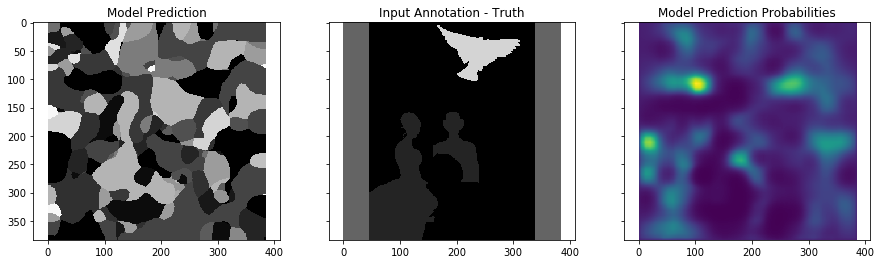

Train step: 100 	Traing Loss: 1.15089 	mIOU: 0.0369192 	Accuracy: 0.452506


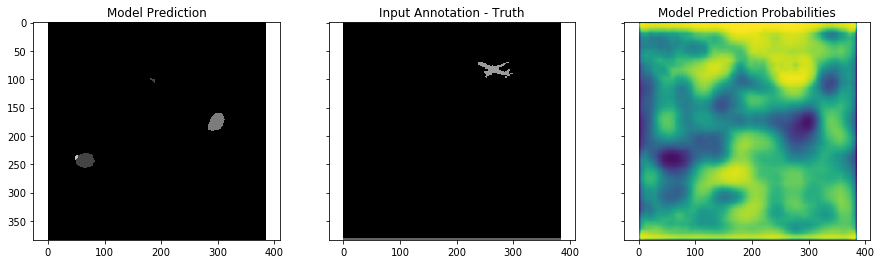

Train step: 200 	Traing Loss: 1.98685 	mIOU: 0.0410082 	Accuracy: 0.494107


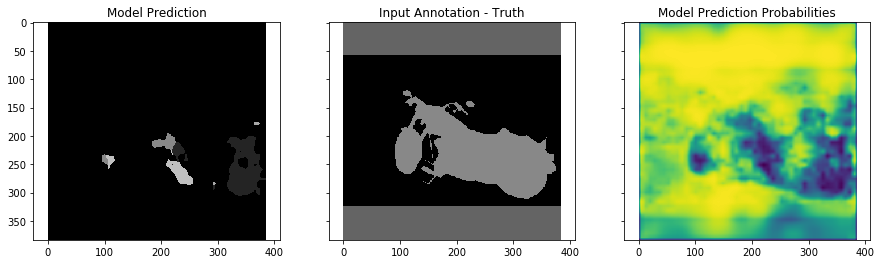

Train step: 300 	Traing Loss: 0.430002 	mIOU: 0.0461354 	Accuracy: 0.501053


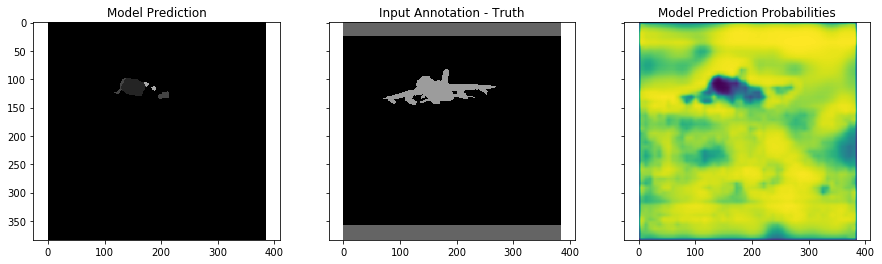

Train step: 400 	Traing Loss: 0.0579455 	mIOU: 0.0531274 	Accuracy: 0.508947


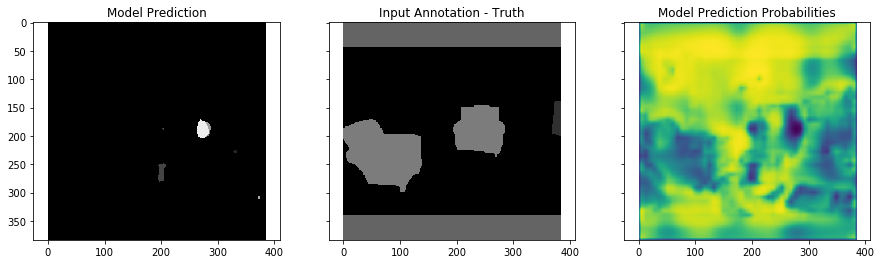

Train step: 500 	Traing Loss: 0.178927 	mIOU: 0.0584804 	Accuracy: 0.518834


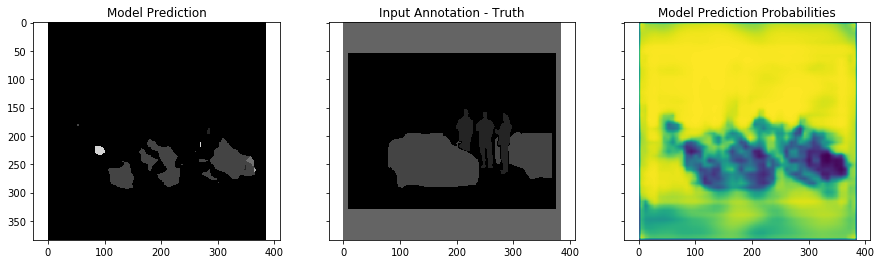

Train step: 600 	Traing Loss: 0.607585 	mIOU: 0.0668096 	Accuracy: 0.527104


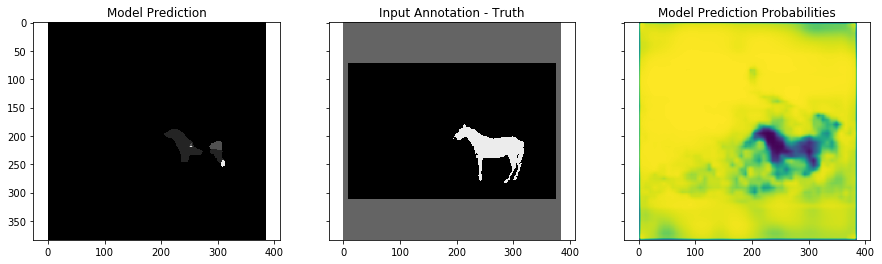

Train step: 700 	Traing Loss: 0.586329 	mIOU: 0.0764131 	Accuracy: 0.532938


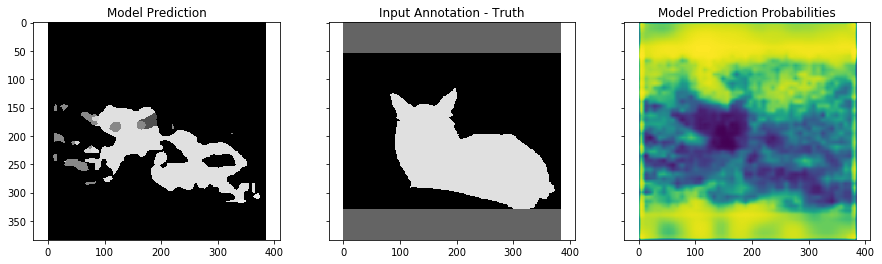

Train step: 800 	Traing Loss: 0.269703 	mIOU: 0.0846518 	Accuracy: 0.532547


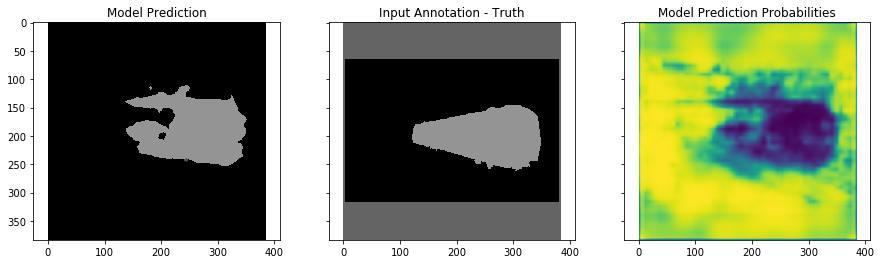

Train step: 900 	Traing Loss: 1.05859 	mIOU: 0.0945573 	Accuracy: 0.536007


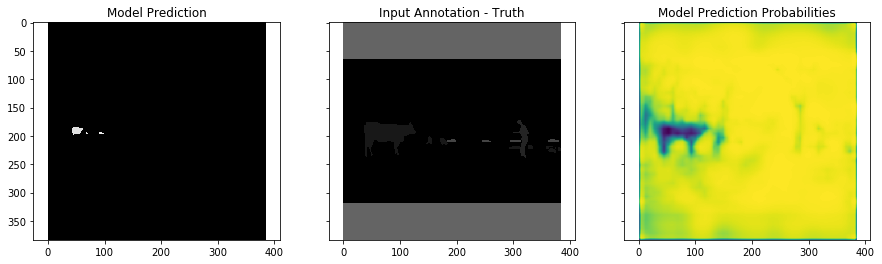

Train step: 1000 	Traing Loss: 0.484617 	mIOU: 0.106073 	Accuracy: 0.538478


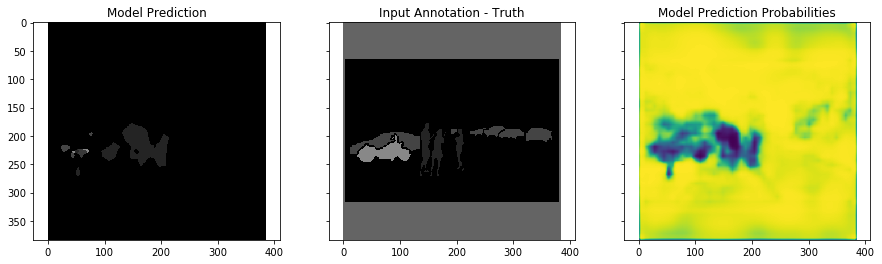

Train step: 1100 	Traing Loss: 0.274353 	mIOU: 0.11423 	Accuracy: 0.542969


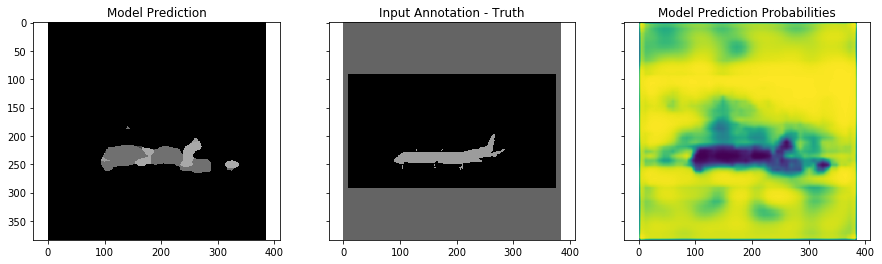

Train step: 1200 	Traing Loss: 0.535449 	mIOU: 0.125945 	Accuracy: 0.543936


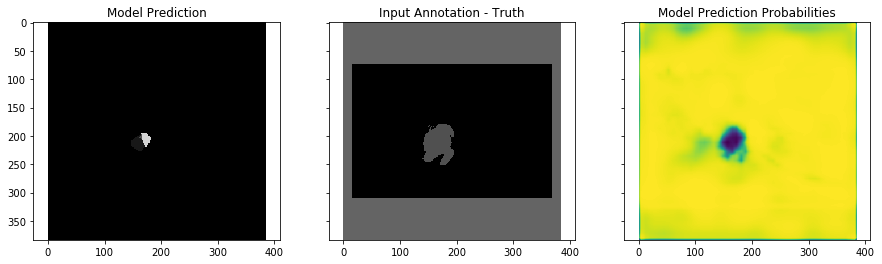

Train step: 1300 	Traing Loss: 0.203539 	mIOU: 0.139139 	Accuracy: 0.546325


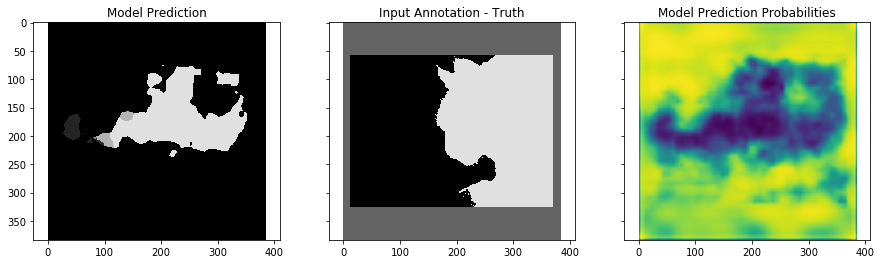

Train step: 1400 	Traing Loss: 0.936522 	mIOU: 0.152076 	Accuracy: 0.549276


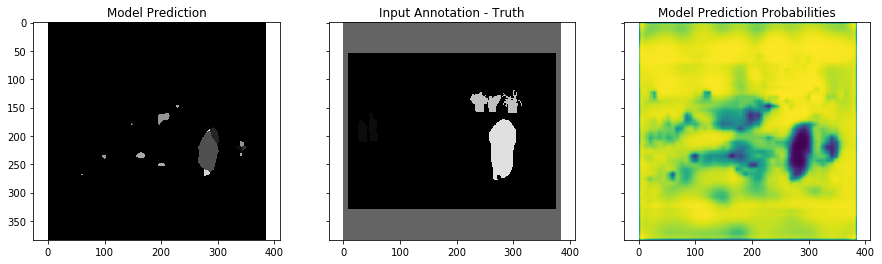

Train step: 1500 	Traing Loss: 0.256046 	mIOU: 0.163758 	Accuracy: 0.550347


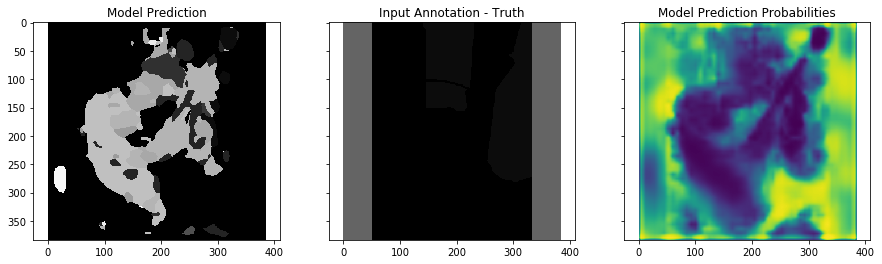

Train step: 1600 	Traing Loss: 0.296936 	mIOU: 0.172209 	Accuracy: 0.553099


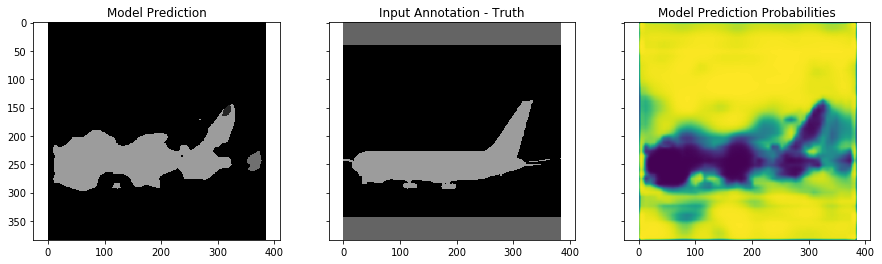

In [ ]:
# Initializer for new fc8 weights -- for two classes.
vgg_fc8_weights_initializer = tf.variables_initializer(vgg_fc8_weights)

# Initializer for adam variables
optimization_variables_initializer = tf.variables_initializer(adam_optimizer_variables)

model_vars = tf.variables_initializer(model_variables)

# Create a saver.
saver = tf.train.Saver()

with tf.Session() as sess:
    
    # Run the initializers.
    read_vgg_weights_except_fc8_func(sess)
    sess.run(vgg_fc8_weights_initializer)
    sess.run(optimization_variables_initializer)
    sess.run(tf.local_variables_initializer())
    sess.run(model_vars)
    
    # Start input enqueue threads.
    coord = tf.train.Coordinator()
    threads = tf.train.start_queue_runners(sess=sess, coord=coord)
    step = 0
    try:
        while not coord.should_stop():

            _, train_loss, tmp1, tmp2 = sess.run([train_step, cross_entropy_sum, miou_update_op, acc_update_op],
                                                                            feed_dict={is_training_placeholder: True})

            if step % 100 == 0:
                
                pred_np, batch_annotations, probabilities_np = sess.run([pred, batch_labels, probabilities],
                                                                        feed_dict={is_training_placeholder: True})
                
                miou_np = sess.run(miou)
                accuracy = sess.run(acc)
                
                pred_annotation = np.expand_dims(pred_np[0], axis=2).astype(float)
                print("Train step:", step, "\tTraing Loss:", train_loss, "\tmIOU:", miou_np, "\tAccuracy:", accuracy)
            
                cmap = plt.get_cmap('bwr')
                f, (ax1, ax2, ax3) = plt.subplots(1, 3, sharey=True)
                f.set_figheight(4)
                f.set_figwidth(15)
                
                ax1.imshow(np.dstack((pred_annotation,)*3)*100)
                ax1.set_title('Model Prediction')
                
                probability_graph = ax2.imshow(np.dstack((batch_annotations[0].astype(float),)*3)*100)
                ax2.set_title('Input Annotation - Truth')
                
                probability_graph = ax3.imshow(probabilities_np[0].squeeze()[:, :, 0])
                ax3.set_title('Model Prediction Probabilities')
                plt.show()

            step += 1
    
    except tf.errors.OutOfRangeError:
        print('Done training -- epoch limit reached')
        saver.save(sess, './checkpoints_2/FCNCheckpoints')
        
    finally:
        # When done, ask the threads to stop.
        coord.request_stop()
        
    # Wait for threads to finish.
    coord.join(threads)
    summary_string_writer.close()

# Validation

In [7]:
validation_filenames = "/home/thalles/VOC2012/ImageSets/Segmentation/val.txt"
training_images_dir = "/home/thalles/VOC2012/JPEGImages/"
training_labels_dir = "/home/thalles/VOC2012/SegmentationClass_1D/"
image_size=[384, 384]

In [8]:
filename_queue = tf.train.string_input_producer([validation_filenames], num_epochs=1)
reader = tf.TextLineReader()
key, img_filename = reader.read(filename_queue)

# read the input and annotation images
image_tensor = tf.read_file(training_images_dir + img_filename + ".jpg")
annotation_tensor = tf.read_file(training_labels_dir + img_filename + ".png")

image_tensor = tf.image.decode_jpeg(image_tensor, channels=3)
annotation_tensor = tf.image.decode_png(annotation_tensor, channels=1)

resized_image, resized_annotation = scale_randomly_image_with_annotation_with_fixed_size_output(image_tensor, annotation_tensor, image_size)
resized_image = _mean_image_subtraction(resized_image, [_R_MEAN, _G_MEAN, _B_MEAN])

num_examples_per_epoch = len(training_filenames)
min_fraction_of_examples_in_queue = 0.05
min_queue_examples = int(num_examples_per_epoch * min_fraction_of_examples_in_queue)

resized_annotation = tf.squeeze(resized_annotation)
batch_images, batch_labels = tf.train.shuffle_batch([resized_image, resized_annotation],
                                             batch_size=1,
                                             capacity=3000,
                                             num_threads=2,
                                             min_after_dequeue=1000)

In [9]:
is_training_placeholder = model_input()
upsampled_by_factor_16_logits = model(batch_images, number_of_classes=number_of_classes, 
                                      is_training=is_training_placeholder)

pred = tf.argmax(upsampled_by_factor_16_logits, dimension=3)
probabilities = tf.nn.softmax(upsampled_by_factor_16_logits)

In [10]:
# Define the accuracy metric: Mean Intersection Over Union
miou, miou_update_op = slim.metrics.streaming_mean_iou(predictions=pred,
                                                   labels=batch_labels,
                                                   num_classes=number_of_classes)

acc, acc_update_op = slim.metrics.streaming_accuracy(predictions=pred, 
                                                labels=batch_labels, 
                                                name="pixel_accuracy")

In [11]:
saver = tf.train.Saver()
with tf.Session() as sess:
    sess.run(tf.local_variables_initializer())
    # Restore variables from disk.
    saver.restore(sess, "./checkpoints_2/FCNCheckpoints")
    print("Model restored.")

    # Start input enqueue threads.
    coord = tf.train.Coordinator()
    threads = tf.train.start_queue_runners(sess=sess, coord=coord)
    
    try:
        while not coord.should_stop():
            pred_np, probabilities_np, image, annotation, tmp1, tmp2 = sess.run([pred, probabilities, 
                                                                     batch_images, batch_labels, miou_update_op, acc_update_op],
                                                                     feed_dict={is_training_placeholder: False})
            
            
            
            #cmap = plt.get_cmap('bwr')
            #f, (ax1, ax2, ax3, ax4) = plt.subplots(1, 4, sharey=True)
            #f.set_figheight(4)
            #f.set_figwidth(18)
            
            #ax1.imshow(image.squeeze()[:, :, 0])
            #ax1.set_title('Input Image - Truth')
            
            #probability_graph = ax2.imshow(np.dstack((annotation[0].astype(float),)*3)*100)
            #ax2.set_title('Input Annotation - Truth')
                
            #ax3.imshow(np.squeeze(pred_np))
            #probability_graph = ax4.imshow(probabilities_np[0].squeeze()[:, :, 0])

            #plt.colorbar(probability_graph)
            #plt.show()

    except tf.errors.OutOfRangeError:
        print('Done training -- epoch limit reached')
        miou_np = sess.run(miou)
        accuracy = sess.run(acc)
        print("\tmIOU:", miou_np, "\tPixel Accuracy:", accuracy)
    finally:
        # When done, ask the threads to stop.
        coord.request_stop()

    # Wait for threads to finish.
    coord.join(threads)

INFO:tensorflow:Restoring parameters from ./checkpoints_2/FCNCheckpoints
Model restored.
Done training -- epoch limit reached
	mIOU: 0.460244 	Accuracy: 0.6146


In [ ]:
print(pred_np.shape)
print(pred_np[np.where(pred_np != 0)])
plt.imshow(np.squeeze(pred_np))